# CNN for Classification
---
In this and the next notebook, we define **and train** a CNN to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist). 

We are providing two solutions to show you how different network structures and training strategies can affect the performance and accuracy of a CNN. This first solution will be a simple CNN with two convolutional layers. 

Please note that this is just one possible solution out of many!

### Load the [data](https://pytorch.org/docs/stable/torchvision/datasets.html)

In this cell, we load in both **training and test** datasets from the FashionMNIST class.

In [15]:
# basic libs
import torch
import torchvision

# data loading and transforming utils 
from torchvision.datasets import FashionMNIST 
from torch.utils.data import DataLoader
from torchvision import transforms 

# the output of torchvision datasets are PILImage images of range [0, 1]
# we need to transform them to Tensors to fit as an input for a CNN

# define the transform to be applied the data while loading it
data_transform = transforms.ToTensor()

# select the training and test data sets 
train_data = FashionMNIST(root='./data', train=True, download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False, download=True, transform=data_transform)

# print some states about the training/testing data 
print('Training data number of samples is ', len(train_data))
print('Testing data number of samples is ', len(test_data))

Training data number of samples is  60000
Testing data number of samples is  10000


In [16]:
# prepare train/test data loaders, shuffle the data, and set batch size 
batch_size = 20 

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# name the ten images classes
classes = ['T-shirt', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneakers','Bag','Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

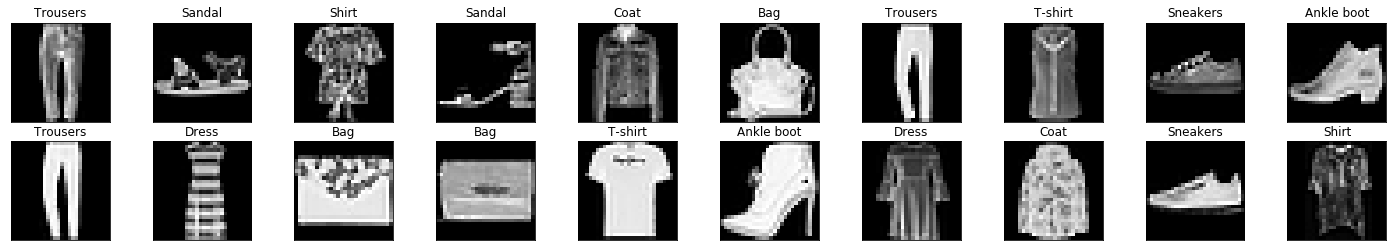

In [17]:
# for visualization 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# get one batch from the training data images
dataiter = iter(train_loader)
images, labels = dataiter.next() 
images = images.numpy() 

# plot batch images with their labels 
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2,batch_size/2, idx+1, xticks = [], yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

The various layers that make up any neural network are documented, [here](https://pytorch.org/docs/stable/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers
* [Dropout layers](https://pytorch.org/docs/stable/nn.html#dropout) 

### A note on output size

For any convolutional layer, the output feature maps will have the specified depth (a depth of 10 for 10 filters in a convolutional layer) and the dimensions of the produced feature maps (width/height) can be computed as the _input image_ width/height, W, minus the filter size, F, divided by the stride, S, all + 1. The equation looks like: `output_dim = (W-F)/S + 1`, for an assumed padding size of 0. You can find a derivation of this formula, [here](http://cs231n.github.io/convolutional-networks/#conv).

For a pool layer with a size 2 and stride 2, the output dimension will be reduced by a factor of 2. Read the comments in the code below to see the output size for each layer.

#### Flattening

Recall that to move from the output of a convolutional/pooling layer to a linear layer, you must first flatten your extracted features into a vector. If you've used the deep learning library, Keras, you may have seen this done by `Flatten()`, and in PyTorch you can flatten an input `x` with `x = x.view(x.size(0), -1)`.

In [18]:
# build the CNN
# basic libs
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # call the base class constructor

        # build the layers
        # 1 input image channel (grayscale) with size (28, 28), and I selected 10 output channels/feature maps
        self.conv1 = nn.Conv2d(1, 10, 3)
        # output size = (W-F)/S+1 = 28 - 3 + 1 = 26 (W is input width, F is filter size, S is stride)
        # output tensor becomes (10, 26, 26). Input was (1, 28, 28)
        # after pooling with (2,2) size kernel, the output becomes (10, 13, 13)

        self.pool = nn.MaxPool2d(2, 2)

        # 1 input now has 10 channels, we are free to set the output channels/feature maps
        self.conv2 = nn.Conv2d(10, 20, 3)
        # output size = (W-F)/S+1 = 13 - 3 + 1 = 11
        # output tensor becomes (20, 11, 11). Input was (10, 26, 26)
        # after pooling becomes (20, 5, 5)

        # the fully connected layer needs a 1-d vector input
        # create with the flattened input vector size, and number of channels
        self.fc1 = nn.Linear(20*5*5, 50)

        self.fc1_drop = nn.Dropout(p = 0.4)

        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # now, flatten the input to give to fc1
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        x = self.fc1_drop(x)

        x = self.fc2(x)

        return x 

#instantiate and print the CNN 
cnn = Net()
print(cnn)


Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### Specify the loss function and optimizer

Learn more about [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizers](https://pytorch.org/docs/stable/optim.html) in the online documentation.

Note that for a classification problem like this, one typically uses cross entropy loss, which can be defined in code like: `criterion = nn.CrossEntropyLoss()`; cross entropy loss combines `softmax` and `NLL loss` so, alternatively (as in this example), you may see NLL Loss being used when the output of our Net is a distribution of class scores. 

PyTorch also includes some standard stochastic optimizers like stochastic gradient descent and Adam. You're encouraged to try different optimizers and see how your model responds to these choices as it trains.


In [19]:
# load the optimizer
import torch.optim as optim

# cross entropy loss combines softmax and negative log likelihood loss (NLLLoss) in one class.
# no softmax function in the network architecure when this is used 
criterion = nn.CrossEntropyLoss()

# stochastic gradient descent with a small learning rate
optimizer = optim.SGD(cnn.parameters(), lr=0.001)


### Check the network accuracy before training!

It's interesting to look at the accuracy of your network **before and after** training. This way you can really see that your network has learned something. In the next cell, let's see what the accuracy of an untrained network is (we expect it to be around 10% which is the same accuracy as just guessing for all 10 classes).

In [20]:
# inference before training the network! CNN has not idea about the data

correct = 0
total = 0

# iterate over the test data
for images, labels in test_loader: 
    
    # give input images to the net as an input 
    # outputs have the returned class scores 
    outputs = cnn(images)

    # get the predicted class as the max value in the output class scores
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum() 


# accuracy 
accuracy = 100.0 * correct.item() / total 

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  10.37


### Train the Network

The `train` function that takes in a number of epochs to train for. 
* The number of epochs is how many times a network will cycle through the entire training dataset. 
* Inside the epoch loop, we loop over the training dataset in batches; recording the loss every 1000 batches.

The steps that the training function performs as it iterates over the training dataset:

1. Zeros the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss (how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network’s parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss



In [21]:
def train(n_epochs):
    loss_over_time = [] # over all training

    for epoch in range(n_epochs):         
        running_loss = 0.0 # for a single epoch

        for batch_i, data in enumerate(train_loader): 
            # get input images and their labels
            inputs, labels = data 

            # zero the gradients/weights in the network
            optimizer.zero_grad()  

            # forward pass to get output
            outputs = cnn(inputs)

            # compare outputs with labels to calculate loss
            loss = criterion(outputs, labels)

            # backward pass to update the parameter gradients/weights (back propagate)
            loss.backward()

            # update the parameters/weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
                        
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0



    print('Finished Training')
    return loss_over_time

In [22]:
# define the number of epochs to train for
n_epochs = 30 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 2.2964010181427
Epoch: 1, Batch: 2000, Avg. Loss: 2.274770787715912
Epoch: 1, Batch: 3000, Avg. Loss: 2.2238789768218994
Epoch: 2, Batch: 1000, Avg. Loss: 2.026591135263443
Epoch: 2, Batch: 2000, Avg. Loss: 1.6081260466575622
Epoch: 2, Batch: 3000, Avg. Loss: 1.3427111761569976
Epoch: 3, Batch: 1000, Avg. Loss: 1.1990198909044265
Epoch: 3, Batch: 2000, Avg. Loss: 1.1059266504645349
Epoch: 3, Batch: 3000, Avg. Loss: 1.047623461276293
Epoch: 4, Batch: 1000, Avg. Loss: 1.0034871034622193
Epoch: 4, Batch: 2000, Avg. Loss: 0.9590911472141743
Epoch: 4, Batch: 3000, Avg. Loss: 0.9427719689905644
Epoch: 5, Batch: 1000, Avg. Loss: 0.9124176002144814
Epoch: 5, Batch: 2000, Avg. Loss: 0.9045430628359318
Epoch: 5, Batch: 3000, Avg. Loss: 0.8784578609466552
Epoch: 6, Batch: 1000, Avg. Loss: 0.868887099802494
Epoch: 6, Batch: 2000, Avg. Loss: 0.8611275893449784
Epoch: 6, Batch: 3000, Avg. Loss: 0.8340000827610493
Epoch: 7, Batch: 1000, Avg. Loss: 0.8316631096601487


## Visualizing the loss

A good indication of how much your network is learning as it trains is the loss over time. In this example, we printed and recorded the average loss for each 1000 batches and for each epoch. Let's plot it and see how the loss decreases (or doesn't) over time.

In this case, you can see that it takes a little bit for a big initial loss decrease, and the loss is flattening out over time.

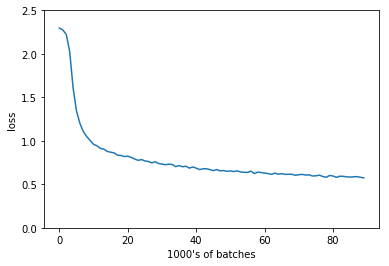

In [23]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

### Test the Trained Network

Once you are satisfied with how the loss of your model has decreased, there is one last step: test!

You must test your trained model on a previously unseen dataset to see if it generalizes well and can accurately classify this new dataset. For FashionMNIST, which contains many pre-processed training images, a good model should reach **greater than 85% accuracy** on this test dataset. If you are not reaching this value, try training for a larger number of epochs, tweaking your hyperparameters, or adding/subtracting layers from your CNN.

In [25]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
cnn.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = cnn(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.517716

Test Accuracy of T-shirt: 78% (784/1000)
Test Accuracy of Trousers: 95% (955/1000)
Test Accuracy of Pullover: 71% (710/1000)
Test Accuracy of Dress: 87% (871/1000)
Test Accuracy of  Coat: 76% (764/1000)
Test Accuracy of Sandal: 91% (912/1000)
Test Accuracy of Shirt: 22% (227/1000)
Test Accuracy of Sneakers: 93% (936/1000)
Test Accuracy of   Bag: 95% (955/1000)
Test Accuracy of Ankle boot: 92% (927/1000)

Test Accuracy (Overall): 80% (8041/10000)


### Visualize sample test results

Format: predicted class (true class)

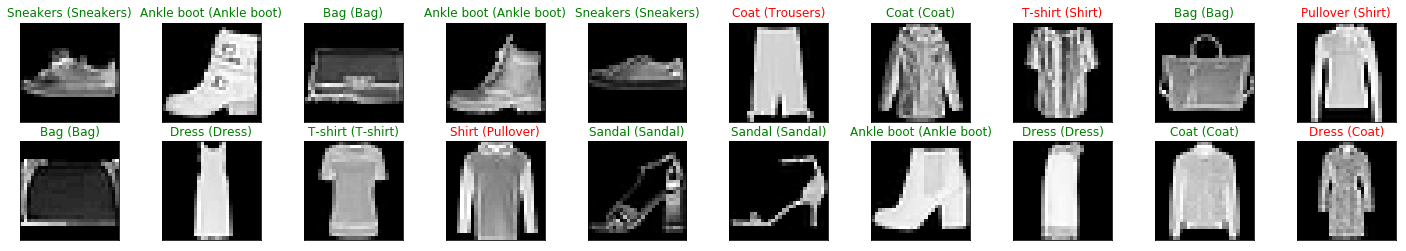

In [26]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(cnn(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

The model is overfitting certain classes at the cost of generalization. I suspect that this accuracy could be improved by adding some dropout layers to aoid overfitting.

In [27]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'fashion_net_improved.pt'

# after training, save the model parameters in the dir 'saved_models'
torch.save(cnn.state_dict(), model_dir+model_name)